In [8]:
!pip3 install --upgrade pip

Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 1.7MB 5.7MB/s eta 0:00:01
imageio 2.16.0 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [6]:
!pip3 install tensorflow numpy scikit-image matplotlib pillow opencv-python

  Using cached https://files.pythonhosted.org/packages/dd/09/e1fc94c28b96f16078c347eda89f6b0640106160588131d8c4e2d507d185/tensorflow-2.6.2-cp36-cp36m-macosx_10_11_x86_64.whl
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/77/16/458f59fe1cac841b7b1ce13fb470eba080164aea3184840ed1bb3ced9e1f/opencv-python-4.10.0.82.tar.gz
  Missing build time requirements in pyproject.toml for opencv-python from https://files.pythonhosted.org/packages/77/16/458f59fe1cac841b7b1ce13fb470eba080164aea3184840ed1bb3ced9e1f/opencv-python-4.10.0.82.tar.gz#sha256=dbc021eaa310c4145c47cd648cb973db69bb5780d6e635386cd53d3ea76bd2d5: 'wheel'.
  This version of pip does not implement PEP 517 so it cannot build a wheel without 'setuptools' and 'wheel'.
  Could not find a version that satisfies the requirement numpy==1.21.0 (from versions: 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from skimage.color.colorconv import lab2rgb, gray2rgb

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class FusionLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        imgs, embs = inputs
        batch_size = tf.shape(imgs)[0]
        height = tf.shape(imgs)[1]
        width = tf.shape(imgs)[2]
        emb_depth = tf.shape(embs)[-1]

        embs = tf.reshape(embs, (batch_size, -1))
        embs = tf.repeat(embs, repeats=height * width, axis=1)
        embs = tf.reshape(embs, (batch_size, height, width, emb_depth))

        return tf.concat([imgs, embs], axis=-1)

    def compute_output_shape(self, input_shapes):
        assert input_shapes and len(input_shapes) == 2
        imgs_shape, embs_shape = input_shapes
        assert imgs_shape[0] == embs_shape[0]
        return imgs_shape[:3] + (imgs_shape[3] + embs_shape[-1],)


In [3]:
class Colorization:
    def __init__(self, depth_after_fusion):
        self.encoder = self.build_encoder()
        self.fusion = FusionLayer()
        self.after_fusion = Conv2D(depth_after_fusion, (1, 1), activation='relu')
        self.decoder = self.build_decoder(depth_after_fusion)

    def build_encoder(self):
        input_layer = Input(shape=(None, None, 1), name='encoder_input')
        x = Conv2D(64, (3, 3), activation="relu", padding="same", strides=2)(input_layer)  # 112x112
        x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(128, (3, 3), activation="relu", padding="same", strides=2)(x)  # 56x56
        x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(256, (3, 3), activation="relu", padding="same", strides=2)(x)  # 28x28
        x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)  # Ensure 28x28x256 output
        return Model(inputs=input_layer, outputs=x, name='encoder')

    def build_decoder(self, encoding_depth=256):
        input_layer = Input(shape=(None, None, encoding_depth), name='decoder_input')
        x = Conv2D(128, (3, 3), activation="relu", padding="same")(input_layer)
        x = UpSampling2D((2, 2))(x)  # 56x56
        x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)  # 112x112
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        output_layer = Conv2D(2, (3, 3), activation="tanh", padding="same")(x)
        output_layer = UpSampling2D((2, 2))(output_layer)  # 224x224
        return Model(inputs=input_layer, outputs=output_layer, name='decoder')

    def build(self, img_l, img_emb):
        img_enc = self.encoder(img_l)
        fusion = self.fusion([img_enc, img_emb])
        fusion = self.after_fusion(fusion)
        output = self.decoder(fusion)
        return output

In [4]:
width = 224
height = 224
depth = 3
img_shape = (width, height, depth)
embedding_size = 1001
def load_dataset(tfrecords_dir, batch_size,pattern, shuffle=True,):


    files = tf.data.Dataset.list_files(f"{tfrecords_dir}/{pattern}")
    dataset = files.interleave(tf.data.TFRecordDataset, cycle_length=4)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def parse_tfrecord_fn(example):

    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),  # Image filename
        "image_l": tf.io.FixedLenFeature([width * height], tf.float32),
        "image_ab": tf.io.FixedLenFeature([width * height * 2], tf.float32),
        "image_embedding": tf.io.FixedLenFeature([embedding_size], tf.float32),
    }

    parsed_example = tf.io.parse_single_example(example, feature_description)

    image_l = tf.reshape(parsed_example['image_l'], shape=[width, height, 1])
    image_ab = tf.reshape(parsed_example['image_ab'], shape=[width, height, 2])
    image_emb = parsed_example['image_embedding']


    return {"image_l": image_l, "image_ab": image_ab, "image_embedding": image_emb}


In [5]:
def data_generator(dataset):
    for data in dataset:
        yield (data["image_l"], data["image_embedding"]), data["image_ab"]

In [10]:
def train_model(tfrecords_dir, output_dir, run_id, epochs, batch_size, learning_rate, resume=False, checkpoint_epoch=0):
    
    train_dataset = load_dataset(tfrecords_dir, batch_size, "lab_images_*.tfrecord", shuffle=True,)
    val_dataset = load_dataset(tfrecords_dir, batch_size, "val_lab_images_*.tfrecord", shuffle=True,)    

   
    colorization_model = Colorization(depth_after_fusion=256)
    input_l = tf.keras.Input(shape=(224, 224, 1), name='image_l')
    input_emb = tf.keras.Input(shape=([1001]), name='image_embedding')
    output_ab = colorization_model.build(input_l, input_emb)

    
    model = tf.keras.Model(inputs=[input_l, input_emb], outputs=output_ab)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['accuracy'])
    #print(model.summary())

    model_dir = Path(output_dir) / run_id
    model_dir.mkdir(parents=True, exist_ok=True)

    if resume:
        checkpoint_path = model_dir / f"colorization_model_{checkpoint_epoch:02d}.keras" 
        if checkpoint_path.exists():
            print(f"Loading checkpoint: {checkpoint_path}")
            try:
                model.load_weights(checkpoint_path)
            except Exception as e:  # Catch any exceptions during loading
                print(f"Error loading checkpoint: {e}")
                print("Starting training from scratch.")
                initial_epoch = 0
            else:
                initial_epoch = checkpoint_epoch
                print(f"Resuming from epoch {initial_epoch}")
        else:
            print(f"Checkpoint not found at {checkpoint_path}. Starting training from scratch.")
            initial_epoch = 0
    else:
        print("Not resuming training. Starting from scratch.")
        initial_epoch = 0
    
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint(
            filepath=model_dir  / "colorization_model_{epoch:02d}.keras",
            save_best_only=True,
            monitor='val_loss'
        ),
        TensorBoard(log_dir=model_dir / "logs", histogram_freq=1)

    ]
    history = model.fit(data_generator(train_dataset), 
            epochs=epochs,
            steps_per_epoch=10,
            validation_data=data_generator(val_dataset),
            callbacks=callbacks,
            validation_steps=1,
            initial_epoch=initial_epoch,
            verbose=1,
)

    model.save(tf.io.gfile.join(output_dir, run_id, "final_colorization_model.keras"))
    return history

In [11]:
tfrecords_dir = "./tfrecords"
output_dir = "./output"
run_id = "./colorization_run"
epochs = 10
batch_size = 64
learning_rate = 0.001

In [12]:
# Run the training process
history = train_model(tfrecords_dir, output_dir, run_id, epochs, batch_size, learning_rate, resume=True)

Checkpoint not found at output/colorization_run/colorization_model_00.keras. Starting training from scratch.
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 236s 23s/step - accuracy: 0.5656 - loss: 0.0584 - val_accuracy: 0.7402 - val_loss: 0.0129
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 285s 28s/step - accuracy: 0.6641 - loss: 0.0139 - val_accuracy: 0.7548 - val_loss: 0.0111
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 272s 27s/step - accuracy: 0.7288 - loss: 0.0103 - val_accuracy: 0.7771 - val_loss: 0.0122
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 253s 25s/step - accuracy: 0.7463 - loss: 0.0107 - val_accuracy: 0.7550 - val_loss: 0.0104
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 250s 25s/step - accuracy: 0.7472 - loss: 0.0113 - val_accuracy: 0.7283 - val_loss: 0.0112
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 248s 25s/step - accuracy: 0.6977 - loss: 0.0114 - val_accuracy: 0.7315 - val_loss: 0.0083
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 256s 25s/step - accuracy: 0.7336 - loss: 0.0106 - val_accuracy: 0.7256 - val_loss: 0.

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

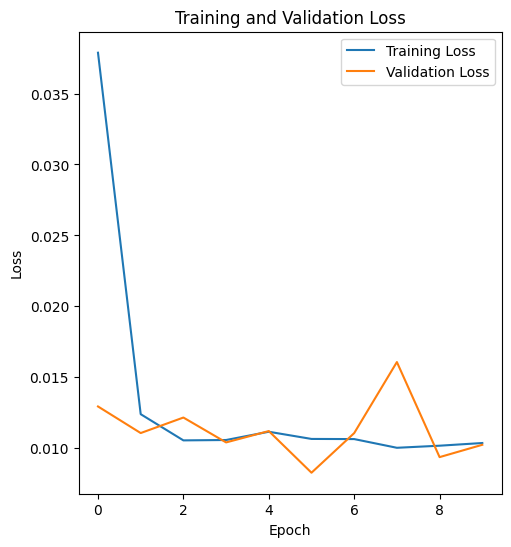

In [14]:
plot_history(history)

In [15]:
print(f'Training Loss: {history.history["loss"][-1]:.4f}')
print(f'Validation Loss: {history.history["val_loss"][-1]  :.4f}')

Training Loss: 0.0104
Validation Loss: 0.0102


In [16]:
def l_to_rgb(img_l):
    lab = np.squeeze(255 * (img_l + 1) / 2)
    return gray2rgb(lab) / 255

def lab_to_rgb(img_l, img_ab):
    lab = np.empty([*img_l.shape[0:2], 3])
    lab[:, :, 0] = np.squeeze(((img_l + 1) * 50))
    lab[:, :, 1:] = img_ab * 127
    return lab2rgb(lab)

In [30]:
def evaluate_model(model, test_dataset, batch_size, num_test_samples=500):

    test_steps = num_test_samples // batch_size

    test_loss = model.evaluate(data_generator(test_dataset), steps=test_steps, verbose=1)[0]
    print(f"Test Loss: {test_loss:.4f}")


def save_results(model, test_dataset, output_dir=None):

    res = {
        "imgs_l": [],
        "imgs_ab": [],
        "imgs_true_ab": [],
        "imgs_emb": [],
    }

    for data in test_dataset:
        img_l, img_ab, embedding = data["image_l"], data["image_ab"], data["image_embedding"]

        output_ab = model.predict([img_l, embedding])

        res["imgs_l"].extend(img_l.numpy())
        res["imgs_ab"].extend(output_ab)
        res["imgs_true_ab"].extend(img_ab.numpy())
        res["imgs_emb"].extend(embedding.numpy())

    for k in range(len(res["imgs_l"])):
        img_gray = l_to_rgb(res["imgs_l"][k][:, :, 0])
        img_output = lab_to_rgb(res["imgs_l"][k][:, :, 0], res["imgs_ab"][k])
        img_true = lab_to_rgb(res["imgs_l"][k][:, :, 0], res["imgs_true_ab"][k])


        plt.subplot(1, 3, 1)
        plt.imshow(img_gray)
        plt.title("Input (grayscale)")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(img_output)
        plt.title("Network output")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(img_true)
        plt.title("Target (original)")
        plt.axis("off")
        
            
        plt.savefig(Path(output_dir) / f"test_{k}.png")
        plt.clf()
        plt.close()    

In [27]:
model_path = "final_colorization_model.keras"
tfrecords_dir = "./tfrecords"  # Replace with your test TFRecord directory
#test_model(model_path, tfrecords_dir, batch_size=16, save_images=True)

In [28]:
model = tf.keras.models.load_model(
    model_path, custom_objects={"FusionLayer": FusionLayer}
)
test_dataset = load_dataset(
    tfrecords_dir, batch_size, "test_lab_images_*.tfrecord", shuffle=False,
)

In [20]:
evaluate_model(model, test_dataset, batch_size, 500)

7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7699 - loss: 0.0110
Test Loss: 0.0113


0.01133487094193697

In [31]:
save_results(model, test_dataset,Path(output_dir) / 'test_results')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


2024-06-11 14:33:47.050156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
